In [ ]:
#| hide
#| default_exp text_classification_sklearn

In [ ]:
#| hide
%matplotlib inline

# "Traditional" Text Classification with Scikit-learn
(follows: https://github.com/nlptown/nlp-notebooks/blob/master/Traditional%20text%20classification%20with%20Scikit-learn.ipynb)

## Data

We investigate techniques that predate deep learning trends in NLP, but are quick & effective ways of training a text classifier.

We use the 20 Newsgroups data set that is shipped with the **Scikit-learn machine learning library**.

It consists of 11_314 training texts and a test set of 7_532 texts.

In [ ]:
#| export
from sklearn.datasets import fetch_20newsgroups

In [ ]:
#| export
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')

print('Training texts: ', len(train_data.data))
print('Test texts: ', len(test_data.data))

Training texts:  11314
Test texts:  7532


## Pre-processing

**Always the first step**: transform the word seqs of the texts into feature vectors. Here we will use BOW approaches. We use `CountVectorizer` to construct vectors that tell us how often a word (or ngram) occurs in a text.

However, texts contain a lot of **uninteresting** words. We use TF-IDF to hunt for words that appear often in a text, but not too often in the corpus as a whole using `TfidfTransformer`.

In order to get these **weighted feature vectors** we combine `CountVectorizer` and `TfidfTransformer` in a `Pipeline`.

In [ ]:
#| export
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

preprocessing = Pipeline([
  ('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer())
])

print('Preprocessing training data ...')
train_preprocessed = preprocessing.fit_transform(train_data.data)
print('Preprocessing test data...')
test_preprocessed = preprocessing.transform(test_data.data)

Preprocessing training data ...
Preprocessing test data...


## Training

Now we can train a **text classifier** on the preprocessed training data. For the training we will experiment with 3 text classification models:

1. **Naive Bayes** classifiers. Simple: They presume all features are independent of each other. They lear how frequent all classes are and how frequent each feature occurs in a class. In order to classify a new text, they multiply the probabilities for every feature xi given each class C and pick the class that gives the highest probability:

$$ \hat{y} = argmax_k p(C_k) \prod_{i=1}^{n}p(x_i | C_k) $$

They are quick to train, but usually fall behind in terms of performance.

2. **Support Vector Machines** try to find the **hyperplane** in feature space that best separates the data from the different classes. They perform really well.

3. **Logistic Regression Models** model the log-odds $l$ or $log(p/(1-p))$ of a class as a linear model and estimate the parameters $\beta$ of the model during training:

$$ l = \beta_0 + \sum_{i=1}^{n}\beta_ix_i $$

Very good performance.

In [ ]:
#| export
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# Setup the three classifiers
nb_classifier = MultinomialNB()
lr_classifier = LogisticRegression(multi_class='ovr')
svm_classifier = LinearSVC()

# Do the actual training
print('Training the Naive Bayes Classifier...')
nb_classifier.fit(train_preprocessed, train_data.target)
print('Training the Logistic Regression Classifier...')
lr_classifier.fit(train_preprocessed, train_data.target)
print('Training the SVM classifier...')
svm_classifier.fit(train_preprocessed, train_data.target)

Training the Naive Bayes Classifier...
Training the Logistic Regression Classifier...
Training the SVM classifier...


LinearSVC()

In order to find out how well each classifier performs, we use their `predict` method the label for all texts in our preprocessed test set.

In [ ]:
#| export
nb_predictions = nb_classifier.predict(test_preprocessed)
lr_predictions = lr_classifier.predict(test_preprocessed)
svm_predictions = svm_classifier.predict(test_preprocessed)

In [ ]:
#| export
# Let's check the prediction scores for each classifier
import numpy as np

print("NB Accuracy:", np.mean(nb_predictions == test_data.target))
print("LR Accuracy:", np.mean(lr_predictions == test_data.target))
print("SVM Accuracy:", np.mean(svm_predictions == test_data.target))

NB Accuracy: 0.7738980350504514
LR Accuracy: 0.8278013807753585
SVM Accuracy: 0.8531598513011153


## Grid search

Not bad scores at all, but with the `GridSearchCV` module we can try to find the optimum hyperparameters:

In [ ]:
#| export
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.logspace(0, 3, 10)}
parameters = {'C': [0.1, 1, 10, 100, 1000]}

print("Grid search for logistic regression")
lr_best = GridSearchCV(lr_classifier, parameters, cv=3, verbose=1)
lr_best.fit(train_preprocessed, train_data.target)

print("Grid search for SVM")
svm_best = GridSearchCV(svm_classifier, parameters, cv=3, verbose=1)
svm_best.fit(train_preprocessed, train_data.target)

Grid search for logistic regression
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Grid search for SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/peter/anaconda3/envs/py38/lib/python3.8/site-pack

GridSearchCV(cv=3, estimator=LinearSVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000]}, verbose=1)

In [ ]:
#| export
# Let's see what hyperparameters lead to the best result

print(f'Best SVM params: {svm_best.best_params_}')
print(f'Best LR params: {lr_best.best_params_}')

Best SVM params: {'C': 1}
Best LR params: {'C': 1000}


Now we can use to these outcomes to, again, calculate predictions on the test set:

In [ ]:
#| export
best_svm_predictions = svm_best.predict(test_preprocessed)
best_lr_predictions = lr_best.predict(test_preprocessed)

print("Best SVM Accuracy:", np.mean(best_svm_predictions == test_data.target))
print("Best LR Accuracy:", np.mean(best_lr_predictions == test_data.target))

Best SVM Accuracy: 0.8531598513011153
Best LR Accuracy: 0.8515666489644185


## Extensive evaluation

### Detailed scores

So far, we looked at the accuracy of our models: The proportion of test examples for which its prediction is correct. But where do things go wrong?

We start with:

1. **Precision** the number of times the classifier predicted a class correctly, divided by the total number of times it predicted this class
2. **Recall** the proportion of documents with a given class that were labelled correctly by the classifier
3. **F1-score** the harmonic mean between precision and recall: $2*P*R/(P + R)$

Let's generate the classification report:

In [ ]:
#| export
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data.target, best_svm_predictions, target_names=test_data.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.80      0.81       319
           comp.graphics       0.76      0.80      0.78       389
 comp.os.ms-windows.misc       0.77      0.73      0.75       394
comp.sys.ibm.pc.hardware       0.71      0.76      0.74       392
   comp.sys.mac.hardware       0.84      0.86      0.85       385
          comp.windows.x       0.87      0.76      0.81       395
            misc.forsale       0.83      0.91      0.87       390
               rec.autos       0.92      0.91      0.91       396
         rec.motorcycles       0.95      0.95      0.95       398
      rec.sport.baseball       0.92      0.95      0.93       397
        rec.sport.hockey       0.96      0.98      0.97       399
               sci.crypt       0.93      0.94      0.93       396
         sci.electronics       0.81      0.79      0.80       393
                 sci.med       0.90      0.87      0.88       396
         

### Confusion matrix

With this matrix we can visualize our results in even more detail. Really good at detecting the errors the classifier makes. Which classes are most often mixed up?

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 [Text(0.5, 0, 'alt.atheism'),
  Text(1.5, 0, 'comp.graphics'),
  Text(2.5, 0, 'comp.os.ms-windows.misc'),
  Text(3.5, 0, 'comp.sys.ibm.pc.hardware'),
  Text(4.5, 0, 'comp.sys.mac.hardware'),
  Text(5.5, 0, 'comp.windows.x'),
  Text(6.5, 0, 'misc.forsale'),
  Text(7.5, 0, 'rec.autos'),
  Text(8.5, 0, 'rec.motorcycles'),
  Text(9.5, 0, 'rec.sport.baseball'),
  Text(10.5, 0, 'rec.sport.hockey'),
  Text(11.5, 0, 'sci.crypt'),
  Text(12.5, 0, 'sci.electronics'),
  Text(13.5, 0, 'sci.med'),
  Text(14.5, 0, 'sci.space'),
  Text(15.5, 0, 'soc.religion.christian'),
  Text(16.5, 0, 'talk.politics.guns'),
  Text(17.5, 0, 'talk.politics.mideast'),
  Text(18.5, 0, 'talk.politics.misc'),
  Text(19.5, 0, 'talk.religion.misc')])

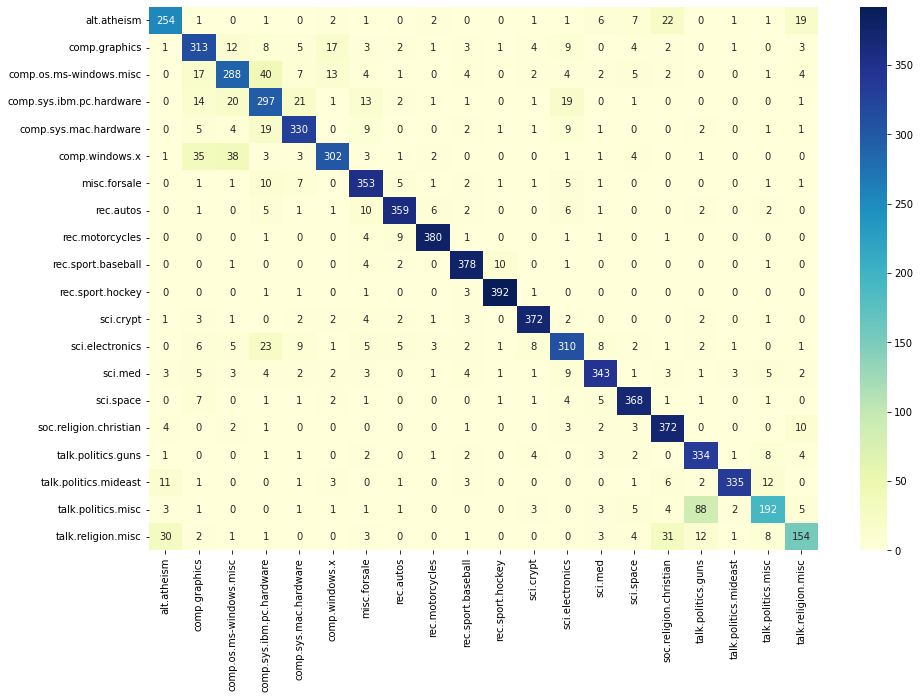

In [ ]:
#| export
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data.target, best_svm_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_data.target_names, columns=test_data.target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap='YlGnBu')
plt.yticks(rotation=0)
plt.xticks(rotation=90)


`talk.politics.misc` was 88 times incorrectly labelled as `talk.politics.gun`. `comp.windows.x` was 35 times incorrectly labelled as `comp.graphics` and 38 times as `comp.os.ms.windows.misc`.

Even more insights can be get by using the `eli5` library. What features get what weights per topic?

In [ ]:
#| export
import eli5

eli5.explain_weights(svm_best.best_estimator_, 
                     feature_names = preprocessing.named_steps["vect"].get_feature_names(),
                     target_names = train_data.target_names
                    )

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Explanation(estimator='LinearSVC(C=1)', description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='alt.atheism', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='atheism', weight=2.444415083062983, std=None, value=None), FeatureWeight(feature='keith', weight=1.9907395301274833, std=None, value=None), FeatureWeight(feature='atheists', weight=1.8064346979903538, std=None, value=None), FeatureWeight(feature='islamic', weight=1.4966381240913142, std=None, value=None), FeatureWeight(feature='cobb', weight=1.4737976097167143, std=None, value=None), FeatureWeight(feature='rushdie', weight=1.460252344418336, std=None, value=None), FeatureWeight(feature='wingate', weight=1.388626619858665, std=None, value=None), FeatureWeight(feature='okcforum', weight=1.3172089074087283, std=None, value=None), FeatureWeight(feature='jaeger', weight=1.2835457122521787, std=None, value=None), FeatureWeight(feature='mangoe', weight=1.269054436043521, std=None, value=None), FeatureWeight(feature='mathew', weight=1.2164328196164396, std=None, value=None), FeatureWeight(feature='enviroleague', weight=1.1876998406169466, std=None, value=None), FeatureWeight(feature='charley', weight=1.1697275542117527, std=None, value=None), FeatureWeight(feature='motto', weight=1.1074871870738334, std=None, value=None), FeatureWeight(feature='livesey', weight=1.107013359678506, std=None, value=None), FeatureWeight(feature='benedikt', weight=1.1025407553597342, std=None, value=None), FeatureWeight(feature='osrhe', weight=1.1024314893401095, std=None, value=None), FeatureWeight(feature='tammy', weight=1.0991813637570451, std=None, value=None), FeatureWeight(feature='bsa', weight=1.097072427094274, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-1.0850564166157848, std=None, value=None)], pos_remaining=10889, neg_remaining=34397), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='comp.graphics', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='graphics', weight=3.891138586182437, std=None, value=None), FeatureWeight(feature='3d', weight=2.3465639527546758, std=None, value=None), FeatureWeight(feature='image', weight=2.2826404033646632, std=None, value=None), FeatureWeight(feature='3do', weight=2.1256004108677047, std=None, value=None), FeatureWeight(feature='pov', weight=2.08333999117782, std=None, value=None), FeatureWeight(feature='images', weight=2.0091468124525385, std=None, value=None), FeatureWeight(feature='tiff', weight=1.9832265821241435, std=None, value=None), FeatureWeight(feature='cview', weight=1.9681179846261498, std=None, value=None), FeatureWeight(feature='polygon', weight=1.8168390329063047, std=None, value=None), FeatureWeight(feature='animation', weight=1.7772101062293653, std=None, value=None), FeatureWeight(feature='format', weight=1.5560884680917944, std=None, value=None), FeatureWeight(feature='mpeg', weight=1.5422348145599876, std=None, value=None), FeatureWeight(feature='surface', weight=1.4634544109780896, std=None, value=None), FeatureWeight(feature='sphere', weight=1.4588708656421876, std=None, value=None), FeatureWeight(feature='points', weight=1.3844929078739383, std=None, value=None), FeatureWeight(feature='42', weight=1.2520566176732455, std=None, value=None), FeatureWeight(feature='fractals', weight=1.2474961883970688, std=None, value=None), FeatureWeight(feature='quicktime', weight=1.2471434972957753, std=None, value=None), Fea